### Import useful libraries

In [47]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

import numpy as np

import netCDF4 as nc
from netCDF4 import Dataset as netcdf_dataset

import sys
import os
import gc
import glob

from datetime import date, timedelta, datetime
from odimh5_file import OdimH5File

import csv
import pandas as pd

from pyproj import Proj, Geod

import h5py

import cartopy
from cartopy import config
import cartopy.crs as ccrs

from windrose import WindroseAxes
from matplotlib.offsetbox import AnchoredText

import wradlib

from scipy.interpolate import griddata

from scipy.optimize import least_squares

%matplotlib notebook 
%matplotlib inline

### Define useful functions

In [3]:
def polar_plotter(a, rstart=0, rscale=500, ax=None, **kwargs):
### Function to easily plot a radar PPI
    
    # take care of some keyword arguments
    figsize = kwargs.pop('figsize', (6, 6))
    aspect = kwargs.pop('aspect', 'equal')
    
    # setup figure and axis if missing
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax.set_aspect(aspect)
    
    # assume the dimensions of a are (nrays, nbins)
    nrays, nbins = a.shape
    # define set of angles and radii values
    # angles start at pi/2 to define North and go to -3*pi/2, i.e. clockwise
    theta = np.linspace(np.pi/2, -3*np.pi/2, nrays+1) # radians
    radii = np.linspace(rstart, rscale*nbins, nbins+1) # meters

    # create mesh of coordinates
    Radii, Theta = np.meshgrid(radii, theta)
    
    # transform coordinates
    X = Radii * np.cos(Theta)
    Y = Radii * np.sin(Theta)
    
    #fig, ax = plt.subplots()
    im = ax.pcolormesh(X, Y, a, **kwargs) #, vmin = -30, vmax = 60)
    fig.colorbar(im, ax=ax)
    
    return ax

In [4]:
def height_calc(var,ele,rstart,rscale):
### Function to calculate an approximation of radar height 

    nrays, nbins = var.shape
    # define set of angles and radii values
    theta = np.linspace(0, 2*np.pi, nrays+1) # radians
    radii = np.linspace(rstart, rscale*nbins, nbins+1) # meters
    
    theta = theta[0:-1] 
    radii = radii[1:]

    # create mesh of coordinates
    Radii, Theta = np.meshgrid(radii, theta)
    
    Height = Radii * np.sin(ele*np.pi/180) + (Radii**2)/(2*6370*1000)    

    return Height, Radii, Theta

In [5]:
def texture_calc(ZH, windowsize_a, windowsize_r):
### Function to calculate the texture of a variable    
    
    ZH_var = np.zeros((ZH.shape[0],ZH.shape[1]))
    ZH_var[:] = np.nan
    
    for a in range(windowsize_a, ZH.shape[0] - windowsize_a+1, 1):
        for r in range(windowsize_r, ZH.shape[1] - windowsize_r+1, 1):
            
            if ~np.isnan(ZH[a,r]):     #calculate texture only for pixels with non Nan values
                num = 0                #to count the non NaN pixels around the non-NaN cental pixel
                sum_a = np.float64(0)
                for win_a in range(-int((windowsize_a-1)/2),int((windowsize_a-1)/2+1),1):
                    sum_r = np.float64(0)
                    for win_r in range(-int((windowsize_r-1)/2),int((windowsize_r-1)/2+1),1):
                        if ~np.isnan(ZH[a+win_a,r+win_r]):
                            num = num + 1
                            Zh_n = (ZH[a,r] - ZH[a+win_a,r+win_r])**2
                            sum_r = sum_r + Zh_n
                            del Zh_n            
                    sum_a = sum_a + sum_r
                    
                ZH_var[a,r] = np.sqrt( sum_a/num )  #divide by num instead of windowsize_a*windowsize_r to account for NaNs

    return ZH_var

In [6]:
def VRAD_std_calc(vel, windowsize_a, windowsize_r):
### Function to calculate STD of VRAD, different from function for texute. From Radhakrishna et al., 2019.
    
    ni = 32.001 #m/s
    lam = 0.05326 #m
    tipp = 1/700 #s high-PRF=800Hz, low-PRF=699Hz
    
    vel_var = np.zeros((vel.shape[0],vel.shape[1]))
    vel_var[:] = np.nan
    
    for a in range(windowsize_a, vel.shape[0] - windowsize_a+1, 1):
        for r in range(windowsize_r, vel.shape[1] - windowsize_r+1, 1):
            
            if ~np.isnan(vel[a,r]):     #calculate texture only for pixels with non Nan values
                num = 0                 #to count the non NaN pixels around the non-NaN cental pixel
                sum_A = np.float64(0)
                sum_B = np.float64(0)
                for win_a in range(-int((windowsize_a-1)/2),int((windowsize_a-1)/2+1),1):
                    #print(win_a)
                    for win_r in range(-int((windowsize_r-1)/2),int((windowsize_r-1)/2+1),1):
                        #print(win_r)
                        if ~np.isnan(vel[a+win_a,r+win_r]):
                            num = num + 1
                                                                        
                            A = np.cos(np.pi*vel[a+win_a,r+win_r]/ni)
                            B = np.sin(np.pi*vel[a+win_a,r+win_r]/ni)
                                                       
                            sum_A = sum_A + A
                            sum_B = sum_B + B
                            
                            del A, B
                    
                vel_var[a,r] = lam/(4*np.pi*tipp) * np.sqrt( 2*np.log( 1/np.sqrt((1/num*sum_A)**2 + (1/num*sum_B)**2) ) )

    return vel_var

### Open ERA5 Data 
#### previously downloaded from the Copernicus Climate Data Store https://cds.climate.copernicus.eu/cdsapp#!/home

In [7]:
path = '/media/leo/Extreme SSD/ERA5/'
file_name = path + 'pressure_levels_wind_NLHRW_20190420.nc'

In [8]:
era5_lon = netcdf_dataset(file_name).variables['longitude'][:]     #longitude [degE]
era5_lat = netcdf_dataset(file_name).variables['latitude'][:]      #latitude [degN]
era5_levels = netcdf_dataset(file_name).variables['level'][:]      #pressure levels [hPa]  
era5_u = netcdf_dataset(file_name).variables['u'][:]               #u-component of wind speed at pressure levels
era5_v = netcdf_dataset(file_name).variables['v'][:]               #v-componenet of wind speed at pressure levels 

In [31]:
print('longitude: ', era5_lon)
print('latitude: ', era5_lat)
print('shape of velocity fileds: ', np.shape(era5_u))

longitude:  [3.   3.25 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25
 6.5  6.75 7.  ]
latitude:  [54.   53.75 53.5  53.25 53.   52.75 52.5  52.25 52.   51.75 51.5  51.25
 51.   50.75 50.5  50.25 50.  ]
shape of velocity fileds:  (24, 15, 17, 17)


24: hours in the selected day (20-04-2019)\
15: numer of pressure levels\
17: number of latitude intervals\
17: number of longitude intervals

### Extract altitude levels using standard barometric formula

In [10]:
era5_alt = (1-(era5_levels*100/101325)**(1/5.25588))/2.25577/10**(-5)
print('levels [hPA]: ',era5_levels)
print('altitudes [m]: ',era5_alt)

levels [hPA]:  [ 550  600  650  700  750  775  800  825  850  875  900  925  950  975
 1000]
altitudes [m]:  [4865.213855518363 4206.421473021799 3590.684271663151 3012.1798216020134
 2466.223697209376 2204.2272871693467 1948.9873867966708 1700.126557545488
 1457.2991190688122 1220.1876310503937 988.4998532146823 761.9661071615126
 540.3369775812971 323.3813014848935 110.88440296430244]


### ERA5 time

In [13]:
### Extract the times, in hours since 01-01-1990
hours = netcdf_dataset(file_name).variables['time'][:]

In [14]:
### Convert all hours to datetime
start = datetime(1900,1,1,0,0,0) 
my_dates = []

for i in np.arange(0,len(hours)):
    
    my_hours = int(hours.data[i])
    delta = timedelta(hours=my_hours) 
    offset = start + delta
    #print(offset)
       
    my_dates = np.concatenate((my_dates, offset), axis=None)
    
print(my_dates[0:10])

[datetime.datetime(2019, 4, 20, 0, 0) datetime.datetime(2019, 4, 20, 1, 0)
 datetime.datetime(2019, 4, 20, 2, 0) datetime.datetime(2019, 4, 20, 3, 0)
 datetime.datetime(2019, 4, 20, 4, 0) datetime.datetime(2019, 4, 20, 5, 0)
 datetime.datetime(2019, 4, 20, 6, 0) datetime.datetime(2019, 4, 20, 7, 0)
 datetime.datetime(2019, 4, 20, 8, 0) datetime.datetime(2019, 4, 20, 9, 0)]


In [18]:
### Choose a reference date
ref_date = datetime(2019,4,20,0,0,0)

time_idx = np.where(my_dates==ref_date)
#print(time_idx[0])
print(my_dates[time_idx[0]])

[datetime.datetime(2019, 4, 20, 0, 0)]


### Interpolate ERA5 velocities at new altitude levels
#### Example at radar location

ERA5 altitudes:  [4865.213855518363 4206.421473021799 3590.684271663151 3012.1798216020134
 2466.223697209376 2204.2272871693467 1948.9873867966708 1700.126557545488
 1457.2991190688122 1220.1876310503937 988.4998532146823 761.9661071615126
 540.3369775812971 323.3813014848935 110.88440296430244]
shape ERA5 altitudes:  (15,)
shape ERA5 u:  (15,)

altitude grid:  [ 100  300  500  700  900 1100 1300 1500 1700 1900 2100 2300 2500 2700
 2900 3100 3300 3500 3700 3900 4100 4300 4500 4700 4900]
shape altitude grid:  (25,)

ERA5 u interpolated:  [        nan -6.86588741 -5.3092644  -4.15636975 -3.03829001 -1.98473207
 -1.31642078 -1.11462973 -0.88784854 -1.0583441  -1.6216584  -2.27689036
 -2.88235782 -3.43266361 -3.98296939 -4.35650662 -4.50424305 -4.65197949
 -4.7111754  -4.69692136 -4.68266732 -4.76128718 -4.94552716 -5.12976715
         nan]
shape ERA5 u interpolated:  (25,)


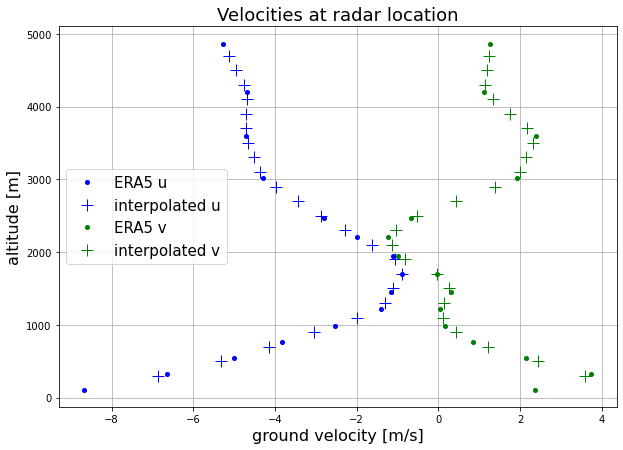

In [27]:
points = era5_alt
print('ERA5 altitudes: ', era5_alt)
print('shape ERA5 altitudes: ', np.shape(era5_alt))

values_u = era5_u[time_idx[0][0],:,8,8].reshape((15))
values_v = era5_v[time_idx[0][0],:,8,8].reshape((15))
print('shape ERA5 u: ', np.shape(values_u))
print('')

alt_grid = np.arange(100,5100,200)
print('altitude grid: ', alt_grid)
print('shape altitude grid: ', np.shape(alt_grid))
print('')


interp_u = griddata(points, values_u, alt_grid, method = 'linear')
interp_v = griddata(points, values_v, alt_grid, method = 'linear')

plt.figure(figsize=(10,7))

plt.plot(values_u, points, 'o', markersize=4, label='ERA5 u',color = 'b')
plt.plot(interp_u, alt_grid, '+', mfc='none', markersize=12, label='interpolated u', color = 'b')

plt.plot(values_v, points, 'o', markersize=4, label='ERA5 v',color = 'g')
plt.plot(interp_v, alt_grid, '+', mfc='none', markersize=12, label='interpolated v', color = 'g')

plt.legend(fontsize=15)
plt.grid()
plt.title('Velocities at radar location',fontsize=18)
plt.xlabel('ground velocity [m/s]',fontsize=16)
plt.ylabel('altitude [m]',fontsize=16)

print('ERA5 u interpolated: ', interp_u)
print('shape ERA5 u interpolated: ',np.shape(interp_u))

### Interpolate ERA5 velocities on new altitude levels for all grid points

In [32]:
grid = np.arange(100,5100,200)
print('altitude grid: ', grid)
print('shape altitude grid: ', np.shape(grid))

points = era5_alt
print('shape era5 altidues: ', np.shape(era5_alt))

era5_u_new = np.empty((24,len(grid),len(era5_lat),len(era5_lon)))
era5_v_new = np.copy(era5_u_new)
era5_u_new[:] = np.nan
era5_v_new[:] = np.nan

for i in np.arange(0,24,1):
    for j in np.arange(0,len(era5_lat),1):
        for k in np.arange(0,len(era5_lon),1):            

            values_u = era5_u[i,:,j,k].reshape((15))
            values_v = era5_v[i,:,j,k].reshape((15))
            
            interp_u = griddata(points, values_u, grid, method = 'linear')
            interp_v = griddata(points, values_v, grid, method = 'linear')
                        
            era5_u_new[i,:,j,k] = interp_u
            era5_v_new[i,:,j,k] = interp_v 
            
print('shape new wind array: ', np.shape(era5_u_new))

altitude grid:  [ 100  300  500  700  900 1100 1300 1500 1700 1900 2100 2300 2500 2700
 2900 3100 3300 3500 3700 3900 4100 4300 4500 4700 4900]
shape altitude grid:  (25,)
shape era5 altidues:  (15,)
shape new wind array:  (24, 25, 17, 17)


### Open Radar Data
#### previously downloaded from MinIo Browser: https://fnwi-s0.science.uva.nl:9001/minio/pvol/ 

In [33]:
files = glob.glob('/media/leo/Extreme SSD/WR Data/NL/HRW/2019/04/20/pvols/NLHRW_pvol_20190420T0040_6356.h5')  
radfile = files[0]
print(radfile)

### Extract elevation info
f= OdimH5File(radfile)
dataset_idx = 6
dataset_path = 'dataset{}'.format(dataset_idx)
where_path = dataset_path + '/where'
ele = f.get_attribute_value(where_path,'elangle')

rstart = f.get_attribute_value(where_path, 'rstart')
rscale = f.get_attribute_value(where_path, 'rscale')

### Extract moments
ZH = f.get_datafield(dataset_path + '/data1')
VRAD = f.get_datafield(dataset_path + '/data5') 
WRAD = f.get_datafield(dataset_path + '/data6')
RHO = f.get_datafield(dataset_path + '/data7')

### VRAD STD
VRAD_std = VRAD_std_calc(VRAD,3,3)

lat_r = f.get_attribute_value('where','lat')
lon_r = f.get_attribute_value('where','lon')
height_r = f.get_attribute_value('where','height')

rad_height, RR, TT = height_calc(VRAD,ele,rstart,rscale)
rad_height = rad_height + height_r

print('radar hieght = ', height_r[0])
print('radar lat = ', lat_r[0])
print('radar lon = ', lon_r[0])


### I previously created a clutter map (for each elevation of radar NLHRW) and stored it in MAP_PATH
MAP_PATH = '/home/leo/proj/weather_radar/clutter_maps/'
radar = 'NLHRW'
map_var = 'TH'
map_date = '20190218'
map_file = glob.glob(MAP_PATH + '{}_{}_var{}_ele{:.2f}_avg_clutter.npy'.format(radar,map_date,map_var,ele[0]))
map_array = np.load(map_file[0])

nr_map = np.shape(map_array)[1]
nr_ZH = np.shape(ZH)[1]
if (nr_map>nr_ZH):
    new_map = map_array[:,0:nr_ZH]
    del map_array
    map_array = new_map
    del new_map

/media/leo/Extreme SSD/WR Data/NL/HRW/2019/04/20/pvols/NLHRW_pvol_20190420T0040_6356.h5
radar hieght =  27.7
radar lat =  51.83689880371094
radar lon =  5.1381001472473145


<AxesSubplot:>

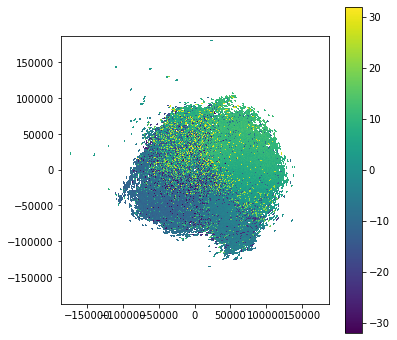

In [34]:
### Example of PPI plot for VRAD
polar_plotter(VRAD,rstart,rscale)

### Convert radar range/azimuth to lon/lat

In [37]:
R = 6378140 #Radius of the Earth [m]

rad_lon = np.copy(RR)
rad_lat = np.copy(RR)
rad_lon[:] = np.nan
rad_lat[:] = np.nan

lat1 = lat_r * (np.pi/180) #radar lat point converted to radians
lon1 = lon_r * (np.pi/180) #radar lon point converted to radians

i = 0
for theta in TT[:,0]:    
       
    j = 0
    for d in RR[0,:]:
                    
        lat2 = np.arcsin( np.sin(lat1)*np.cos(d/R) + np.cos(lat1)*np.sin(d/R)*np.cos(theta))
        lon2 = lon1 + np.arctan2(np.sin(theta)*np.sin(d/R)*np.cos(lat1),np.cos(d/R)-np.sin(lat1)*np.sin(lat2))
        
        lat2 = lat2 * (180/np.pi)
        lon2 = lon2 * (180/np.pi)

        rad_lat[i,j] = lat2
        rad_lon[i,j] = lon2
        
        del lat2, lon2
        
        j=j+1
    
    i=i+1

In [41]:
print('shape radar latitude: ', np.shape(rad_lat))
print('shape radar longitude: ,', np.shape(rad_lon))
print('shape ERA5 latitude: ', np.shape(era5_lat))
print('shape ERA5 longitude: ', np.shape(era5_lon))

shape radar latitude:  (360, 838)
shape radar longitude: , (360, 838)
shape ERA5 latitude:  (17,)
shape ERA5 longitude:  (17,)


### Calcalculate u,v, and w components of VRAD (ele 0.8deg) at ERA5 lon/lat resolution and at 925hPa

- VRAD is radar radial velocity (Doppler) at fixed elevation: ele = 0.8 deg
- RR and TT are radar range and aziuth, respectively
- rad_lat, rad_lon are radar coorinates
- u0, v0, w0 are the velocity to estimate from model: \
 VRAD = cos(ele) sin(TT) u0 + cos(ele) cos(TT) v0 + sin(ele) w0
 

Steps:
1) Divide the VRAD field in a 2D grid:
- 30km x 30km resolution in latitude/longitude, as in ERA5 dataset
- one 200m altitude layer at 925hPa
    
2) Find radar pixels in each resolution box and extract VRAD from them

3) Apply a least square method to estimate VRAD compontnes given the model above. The least square estimation is performed twice, the first time is to filter out the highest residuals.

In [48]:
era5_lat2 = np.append(era5_lat,era5_lat[-1]-0.25)
era5_lon2 = np.append(era5_lon,era5_lon[-1]+0.25) 

rad_u = np.zeros((len(era5_lat),len(era5_lon)))
rad_u[:] = np.nan
rad_v = np.copy(rad_u)

### Define function to model VRAD given x (velocity components), t (azimuth), and y (VRAD reference)
def fun(x, t, y):
    return ((np.cos(ele*np.pi/180)*np.sin(t)*x[0] + np.cos(ele*np.pi/180)*np.cos(t)*x[1] + np.sin(ele*np.pi/180)*x[2]) - y)


for i in np.arange(0,len(era5_lat)):
    #print(i)
    
    for j in np.arange(0,len(era5_lon)):
        #print(j)
        #print('')     
            
        filter_coord = np.all([rad_lat<era5_lat2[i],          #inverse order for lat (high to low)
                               rad_lat>=era5_lat2[i+1],       #lat
                               rad_lon>=era5_lon2[j],         #lon
                               rad_lon<era5_lon2[j+1],        #lon
                               rad_height<era5_alt[-4]+100,   #height th
                               rad_height>=era5_alt[-4]-100,  #hieght th
                               ],axis=0)

        if np.sum(filter_coord==True)>0:

            y = VRAD[filter_coord]
            t = TT[filter_coord]

            y1 = y[~np.isnan(y)] 

            if len(y1)>0:
                print(len(y1))
                #y1 = y[~np.isnan(y)] 
                t1 = t[~np.isnan(y)]
                x0 = np.array([0, 0, 0]) #first estimate of velocities

                #first least squares
                res_lsq1 = least_squares(fun, x0, args=(t1, y1), 
                                        bounds=([-32, -32, -32], [32, 32, 32]))
    
                #filter out high residuals
                filter_res = np.all([res_lsq1.fun<10,  
                                     res_lsq1.fun>-10,
                                    ],axis=0)

                y2 = y1[filter_res]
                t2 = t1[filter_res]
                x1 = res_lsq1.x

                # second least squares
                res_lsq2 = least_squares(fun, x1, args=(t2, y2),
                                        bounds=([-32, -32, -32], [32, 32, 32]))
                print(res_lsq2.x)
                print('')     
                
                rad_u[i,j] = res_lsq2.x[0]
                rad_v[i,j] = res_lsq2.x[1]
                

                del y, t, y1, y2, t1, t2, x0, x1, filter_res, res_lsq1, res_lsq2  


            else:

                print('[nan, nan, nan]')
                print('')
                

        del filter_coord


[nan, nan, nan]

47
[  1.4336089   10.44904158 -31.99999956]

4
[32.          3.18721547 32.        ]

585
[  4.68422344  11.18349245 -32.        ]

630
[  5.32951861  10.19081712 -32.        ]

470
[  6.07381909   9.65303506 -32.        ]

565
[ 5.59306781  9.22755381 32.        ]

1121
[  6.86410406   9.28419025 -31.99999999]

16
[ 11.15165572   1.61043852 -31.99999997]

144
[  4.01342587  22.39270134 -31.99999998]

506
[ 5.29254339 10.98878558 32.        ]

940
[ 5.72339196  9.88410358 32.        ]

637
[ 6.05632286  8.09804442 32.        ]

48
[ 6.09046747 11.12068699 32.        ]

1242
[ 4.92948685 10.53201079 32.        ]

532
[ 4.1195931  11.03790467 32.        ]

45
[  6.29227887   9.26195459 -32.        ]

401
[  2.47877323   7.20419332 -32.        ]

1007
[ 6.77448761 13.08287091 32.        ]

99
[  6.75212363   4.8127837  -32.        ]

6
[-32.          10.91391096  32.        ]

541
[  5.68358049   9.35389638 -31.99999406]

870
[  6.82012948   9.48846048 -31.9999997 ]

579


### Plot radar ground speed (u and v components or VRAD)

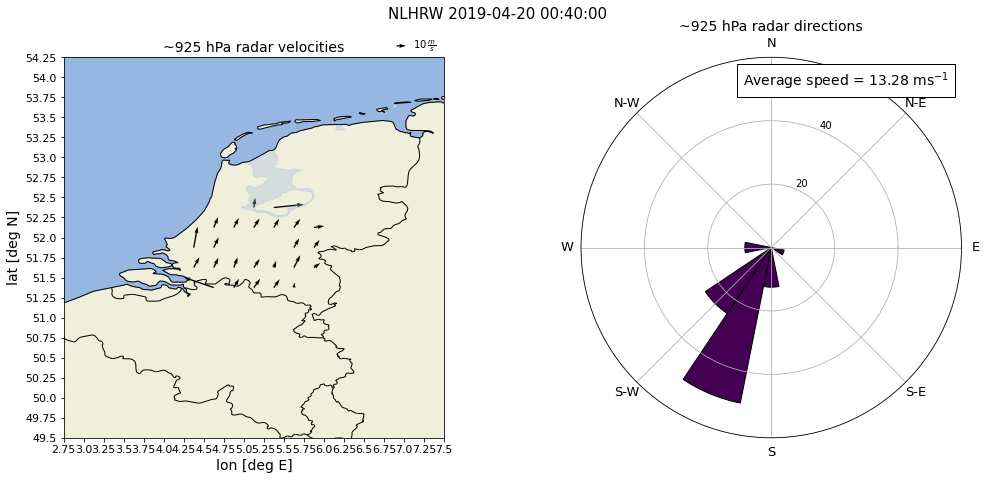

In [49]:
plt.figure(figsize=(17,7))

plt.suptitle('NLHRW 2019-04-20 00:40:00', fontsize = 15)

### quiver map
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.set_title('~925 hPa radar velocities', fontsize = 14) # on + str(ref_date), fontsize = 14)

Q = ax1.quiver(era5_lon+0.125, era5_lat-0.125, rad_u, rad_v, units='width')
ax1.quiverkey(Q, X=0.9, Y=1.03, U=10, label=r'$10\/\frac{m}{s}$', labelpos='E')

ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.RIVERS)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)

ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25), fontsize = 11)

ax1.set_xlim([min(era5_lon2)-0.25, max(era5_lon2)+0.25])
ax1.set_ylim([min(era5_lat2)-0.25, max(era5_lat2)+0.25])


###windrose
uu = rad_u
vv = rad_v
ws = np.sqrt(uu**2 + vv**2)

wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing
#wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction towards which it's blowing

wss=ws[ws>0]
wdd=wd[ws>0]
bins_range = np.arange(0, max(wss), max(wss)) # this sets the legend scale

ax1 = plt.subplot(122, projection='windrose')
plt.title('~925 hPa radar directions', fontsize = 14)
viridis = plt.get_cmap('viridis')            # change colormap to viridis 
ax1.bar(wdd, wss, normed=True, opening=1, edgecolor='black', bins=bins_range, cmap=viridis)
ax1.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'],fontsize=13)
ax1.set_yticks(np.arange(0, 80, step=20))
anchored_text = AnchoredText('Average speed = {:.2f}'.format(np.average(wss)) + ' ms$^{-1}$', loc=1, prop=dict(size=14))
ax1.add_artist(anchored_text)

Note:\
Only the radar elevation 0.8deg was used to obtain VRAD pixels at 925hPa altitude. This is why only a limited area around the radar (NLHRW) is shown in the figure.

### Calcalculate u, v, and w components of radar VRAD (ele 0.8deg) at ERA5 lat/lon resolution

Now there is no limitation on the height interval

In [50]:
era5_lat2 = np.append(era5_lat,era5_lat[-1]-0.25)
era5_lon2 = np.append(era5_lon,era5_lon[-1]+0.25) 

rad_u = np.zeros((len(era5_lat),len(era5_lon)))
rad_u[:] = np.nan
rad_v = np.copy(rad_u)


def fun(x, t, y):
    return ((np.cos(ele*np.pi/180)*np.sin(t)*x[0] + np.cos(ele*np.pi/180)*np.cos(t)*x[1] + np.sin(ele*np.pi/180)*x[2]) - y)


for i in np.arange(0,len(era5_lat)):
    #print(i)
    
    for j in np.arange(0,len(era5_lon)):
        #print(j)
        #print('')     
            
        filter_coord = np.all([rad_lat<era5_lat2[i],          #inverse order for lat (high to low)
                               rad_lat>=era5_lat2[i+1],       #lat
                               rad_lon>=era5_lon2[j],         #lon
                               rad_lon<era5_lon2[j+1],        #lon
                               #rad_height<era5_alt[-4]+100,  #height th
                               #rad_height>=era5_alt[-4]-100, #hieght th
                               ],axis=0)

        if np.sum(filter_coord==True)>0:

            y = VRAD[filter_coord]
            t = TT[filter_coord]

            y1 = y[~np.isnan(y)] 

            if len(y1)>0:
                print(len(y1))
                #y1 = y[~np.isnan(y)] 
                t1 = t[~np.isnan(y)]
                x0 = np.array([0, 0, 0])

                #first least squares
                res_lsq1 = least_squares(fun, x0, args=(t1, y1), 
                                        bounds=([-32, -32, -32], [32, 32, 32]))
    
                #filter out high residuals
                filter_res = np.all([res_lsq1.fun<10,  
                                      res_lsq1.fun>-10,
                                     ],axis=0)

                y2 = y1[filter_res]
                t2 = t1[filter_res]
                x1 = res_lsq1.x

                # second least squares
                res_lsq2 = least_squares(fun, x1, args=(t2, y2),
                                        bounds=([-32, -32, -32], [32, 32, 32]))
                print(res_lsq2.x)
                print('')     
                
                rad_u[i,j] = res_lsq2.x[0]
                rad_v[i,j] = res_lsq2.x[1]
                

                del y, t, y1, y2, t1, t2, x0, x1, filter_res, res_lsq1, res_lsq2  


            else:

                print('[nan, nan, nan]')
                print('')
                

        del filter_coord


[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

1
[ 2.19070559  1.8843309  -4.84822549]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

2
[-2.36926055  2.43595096 -4.99324473]

[nan, nan, nan]

[nan, nan, nan]

1
[-2.18226183  2.17271388 -1.82395664]

[nan, nan, nan]

2
[ 32.          23.77804642 -31.99998957]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

3
[ 0.80703635 -0.80703635 -0.80703635]

[nan, nan, nan]

[nan, nan, nan]

3
[-28.36033373  -3.48822637  27.50393068]

[nan, nan, nan]

[nan, nan, nan]

[nan, nan, nan]

1
[  6.68908469   8.88038076 -16.46916559]

14
[-6.97964571 15.88605249 32.        ]


### Plot radar ground speed (quiver plot) and VRAD

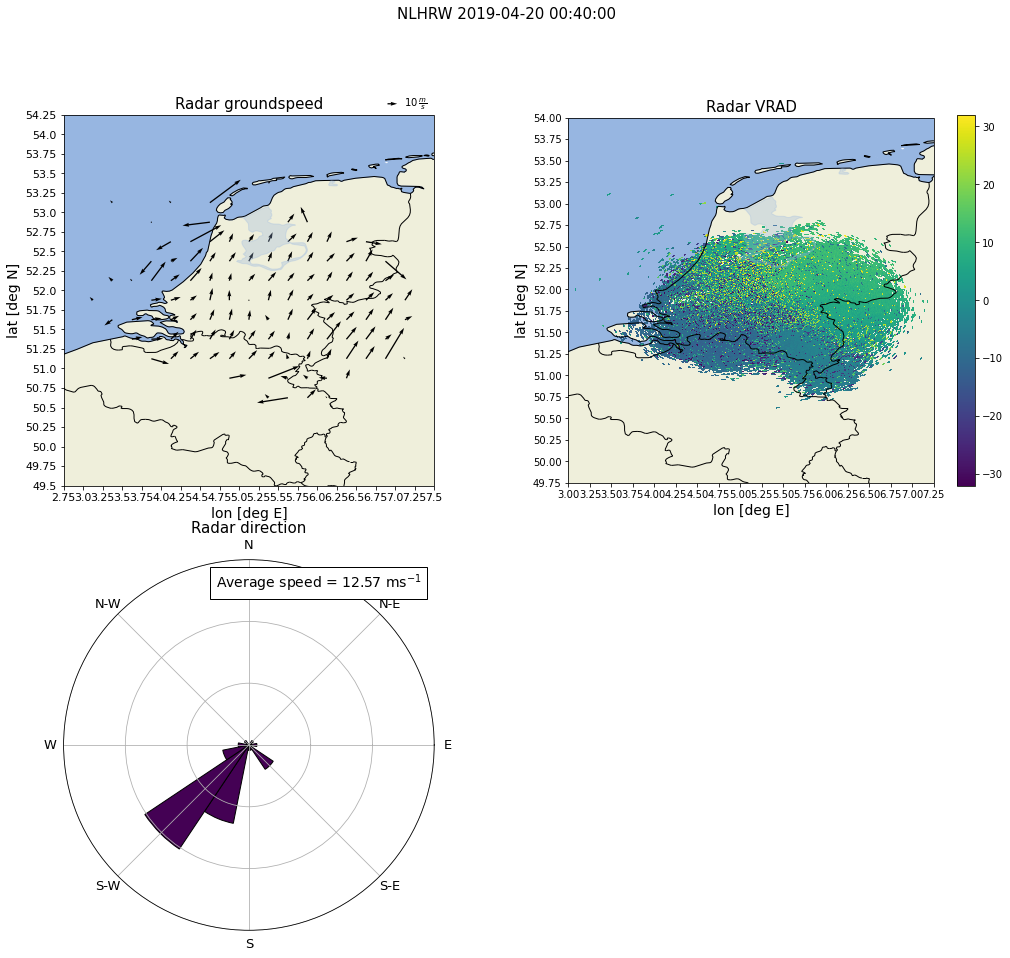

In [115]:
plt.figure(figsize=(18,15))

plt.suptitle('NLHRW 2019-04-20 00:40:00', fontsize = 15)

### Quiver map
ax1 = plt.subplot(221, projection=ccrs.PlateCarree())
ax1.set_title('Radar groundspeed', fontsize = 15) # on + str(ref_date), fontsize = 14)

Q = ax1.quiver(era5_lon+0.125, era5_lat-0.125, rad_u, rad_v, units='width')
ax1.quiverkey(Q, X=0.9, Y=1.03, U=10, label=r'$10\/\frac{m}{s}$', labelpos='E')

ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.RIVERS)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)

ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25), fontsize = 11)

ax1.set_xlim([min(era5_lon2)-0.25, max(era5_lon2)+0.25])
ax1.set_ylim([min(era5_lat2)-0.25, max(era5_lat2)+0.25])


### VRAD PPI
ax1 = plt.subplot(222, projection=ccrs.PlateCarree())
c = ax1.pcolormesh(rad_lon, rad_lat, VRAD) #, vmin=-250000, vmax=500000)
plt.colorbar(c, ax=ax1)
ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))

ax1.set_xlim([min(era5_lon2), max(era5_lon2)])
ax1.set_ylim([min(era5_lat2), max(era5_lat2)])
ax1.set_title('Radar VRAD',fontsize=15)


###windrose
uu = rad_u
vv = rad_v
ws = np.sqrt(uu**2 + vv**2)
wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing
#wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction towards which it's blowing

wss=ws[ws>0]
wdd=wd[ws>0]
bins_range = np.arange(0, max(wss), max(wss)) # this sets the legend scale

ax1 = plt.subplot(223, projection='windrose')
plt.title('Radar direction', fontsize = 15)
viridis = plt.get_cmap('viridis')            # change colormap to viridis 
ax1.bar(wdd, wss, normed=True, opening=1, edgecolor='black', bins=bins_range, cmap=viridis)
ax1.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'],fontsize=13)
ax1.set_yticks(np.arange(0, 80, step=20))
anchored_text = AnchoredText('Average speed = {:.2f}'.format(np.average(wss)) + ' ms$^{-1}$', loc=1, prop=dict(size=14))
ax1.add_artist(anchored_text)

### ERA5 u, v components of wind speed
#### Extract ERA5 wind speed components from ERA5 3D grid to radar scan

- ERA5 grid: lat/lon (30km x 30km), altitude 200m
- radar grid: radar scan at ele = 0.8 deg 

In [58]:
### Initialize ERA5 velocities at radar grid points
Wind_u = np.copy(VRAD)
Wind_u[:] = np.nan
Wind_v = np.copy(VRAD)
Wind_v[:] = np.nan

era5_lat2 = np.append(era5_lat,era5_lat[-1]-0.25)
era5_lon2 = np.append(era5_lon,era5_lon[-1]+0.25) 
grid2 = np.append(grid,grid[-1]+200)

print('ERA5 lat new: ', era5_lat2)
print('ERA5 lon new: ', era5_lon2)
print('ERA5 grid new: ', grid2)


### Find velocities in intervals of latitude, longitude, altitude
for i in np.arange(0,len(era5_lat)): #varies over latitude
    #print(i)
    
    for j in np.arange(0,len(era5_lon)): #varies over longitude
        #print(j)
        #print('')
        
        for k in np.arange(0,len(grid)): #varies over altitude
            #print(k)
            #print('')
            
            filter_all = np.all([rad_lat<era5_lat2[i],  #inverse order for lat (high to low)
                                 rad_lat>=era5_lat2[i+1],
                                 rad_lon>=era5_lon2[j],
                                 rad_lon<era5_lon2[j+1],
                                 rad_height>=grid2[k],
                                 rad_height<grid2[k+1],
                                ],axis=0)
            
            #print(np.sum(filter_all==True))
            
            Wind_u[filter_all] = era5_u_new[time_idx[0][0],k,i,j]
            Wind_v[filter_all] = era5_v_new[time_idx[0][0],k,i,j]
            
            del filter_all

ERA5 lat new:  [54.   53.75 53.5  53.25 53.   52.75 52.5  52.25 52.   51.75 51.5  51.25
 51.   50.75 50.5  50.25 50.   49.75]
ERA5 lon new:  [3.   3.25 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25
 6.5  6.75 7.   7.25]
ERA5 grid new:  [ 100  300  500  700  900 1100 1300 1500 1700 1900 2100 2300 2500 2700
 2900 3100 3300 3500 3700 3900 4100 4300 4500 4700 4900 5100]


#### Plot histograms of wind speed components at 0.8deg elevation scan

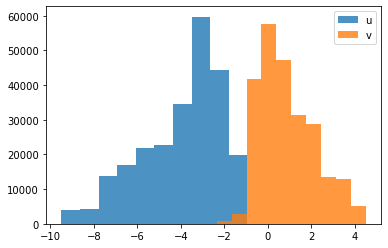

In [63]:
plt.hist(Wind_u[Wind_u>-32], label = 'u', alpha = 0.8)
plt.hist(Wind_v[Wind_v>-32], label = 'v', alpha = 0.8)
plt.legend()

In [64]:
print('shape wind speed u-component: ',np.shape(Wind_u))
print('shape radar groud speed u-component: ',np.shape(rad_u))

shape wind speed u-component:  (360, 838)
shape radar groud speed u-component:  (17, 17)


Note:
- Wind speed components and radar ground speed components have different dimensions
- I need them at the same resolution in order to correct radar speed for wind speed

In [67]:
era5_lat2 = np.append(era5_lat,era5_lat[-1]-0.25)
era5_lon2 = np.append(era5_lon,era5_lon[-1]+0.25) 

### These are wind speed components at 17 x 17 grid 
Wind_u_2 = np.zeros((len(era5_lat),len(era5_lon)))
Wind_u_2[:] = np.nan
Wind_v_2 = np.copy(rad_u)


for i in np.arange(0,len(era5_lat)):
    #print(i)
    
    for j in np.arange(0,len(era5_lon)):
        #print(j)
        #print('')     
            
        filter_coord = np.all([rad_lat<era5_lat2[i],          #inverse order for lat (high to low)
                               rad_lat>=era5_lat2[i+1],       #lat
                               rad_lon>=era5_lon2[j],         #lon
                               rad_lon<era5_lon2[j+1],        #lon
                               ],axis=0)

        if np.sum(filter_coord==True)>0:

            Wind_u_2[i,j] = np.nanmean(Wind_u[filter_coord])
            Wind_v_2[i,j] = np.nanmean(Wind_v[filter_coord])

<ipython-input-67-a3123aad47f8>:25: RuntimeWarning: Mean of empty slice
  Wind_u_2[i,j] = np.nanmean(Wind_u[filter_coord])
<ipython-input-67-a3123aad47f8>:26: RuntimeWarning: Mean of empty slice
  Wind_v_2[i,j] = np.nanmean(Wind_v[filter_coord])


### Calculate radial velocity of wind

In [70]:
VRAD_wind = np.cos(ele*np.pi/180)*np.cos(TT)*Wind_v + np.cos(ele*np.pi/180)*np.sin(TT)*Wind_u

### Plot wind speed (quiver map) and wind radial velocity

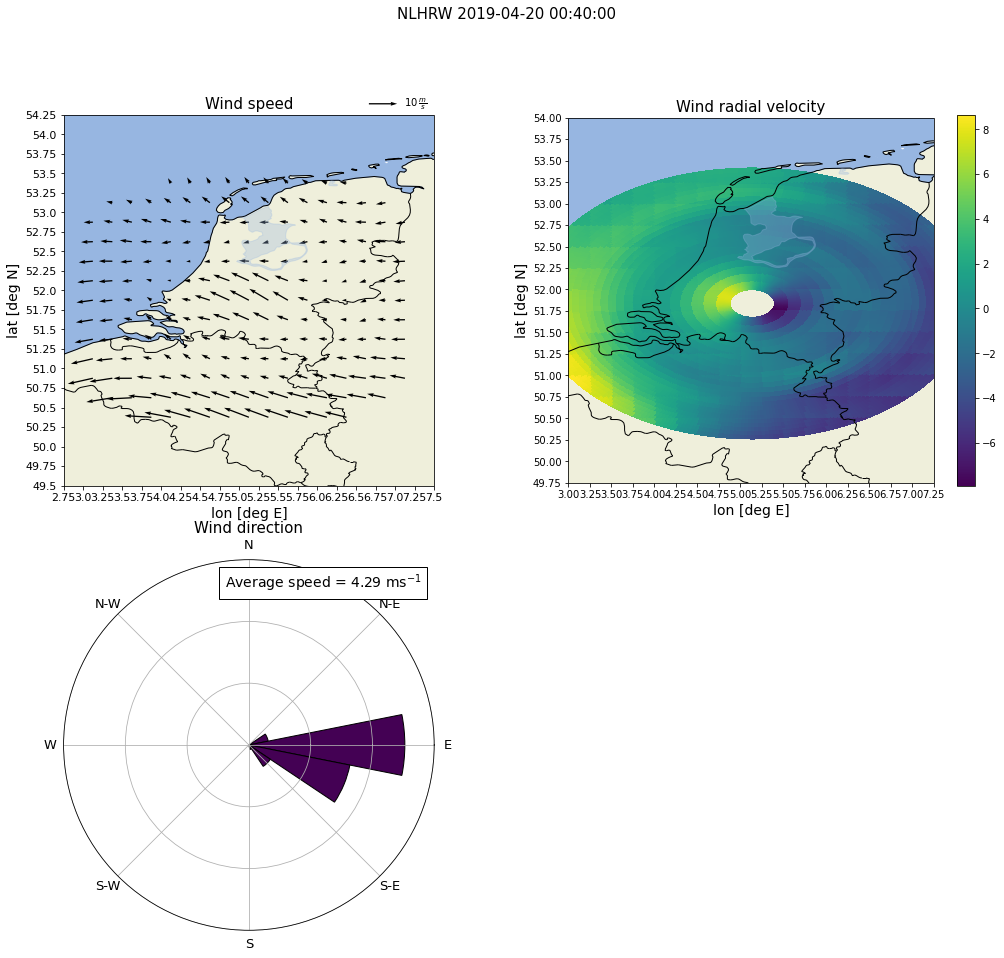

In [114]:
plt.figure(figsize=(18,15))

plt.suptitle('NLHRW 2019-04-20 00:40:00', fontsize = 15)

### Quiver map
ax1 = plt.subplot(221, projection=ccrs.PlateCarree())
ax1.set_title('Wind speed', fontsize = 15) # on + str(ref_date), fontsize = 14)

Q = ax1.quiver(era5_lon+0.125, era5_lat-0.125, Wind_u_2, Wind_v_2, units='width')
ax1.quiverkey(Q, X=0.9, Y=1.03, U=10, label=r'$10\/\frac{m}{s}$', labelpos='E')

ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.RIVERS)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)

ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25), fontsize = 11)

ax1.set_xlim([min(era5_lon2)-0.25, max(era5_lon2)+0.25])
ax1.set_ylim([min(era5_lat2)-0.25, max(era5_lat2)+0.25])


### Wind radial velocity
ax1 = plt.subplot(222, projection=ccrs.PlateCarree())
c = ax1.pcolormesh(rad_lon, rad_lat, VRAD_wind) #, vmin=-250000, vmax=500000)
plt.colorbar(c, ax=ax1)
ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))

ax1.set_xlim([min(era5_lon2), max(era5_lon2)])
ax1.set_ylim([min(era5_lat2), max(era5_lat2)])
ax1.set_title('Wind radial velocity',fontsize=15)


###windrose
uu = rad_u_corr
vv = rad_v_corr
ws = np.sqrt(uu**2 + vv**2)
wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing
#wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction towards which it's blowing

wss=ws[ws>0]
wdd=wd[ws>0]
bins_range = np.arange(0, max(wss), max(wss)) # this sets the legend scale

ax1 = plt.subplot(223, projection='windrose')
plt.title('Wind direction', fontsize = 15)
viridis = plt.get_cmap('viridis')            # change colormap to viridis 
ax1.bar(wdd, wss, normed=True, opening=1, edgecolor='black', bins=bins_range, cmap=viridis)
ax1.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'],fontsize=13)
ax1.set_yticks(np.arange(0, 80, step=20))
anchored_text = AnchoredText('Average speed = {:.2f}'.format(np.average(wss)) + ' ms$^{-1}$', loc=1, prop=dict(size=14))
ax1.add_artist(anchored_text)

### Air speed: radar ground speed - ERA5 wind speed

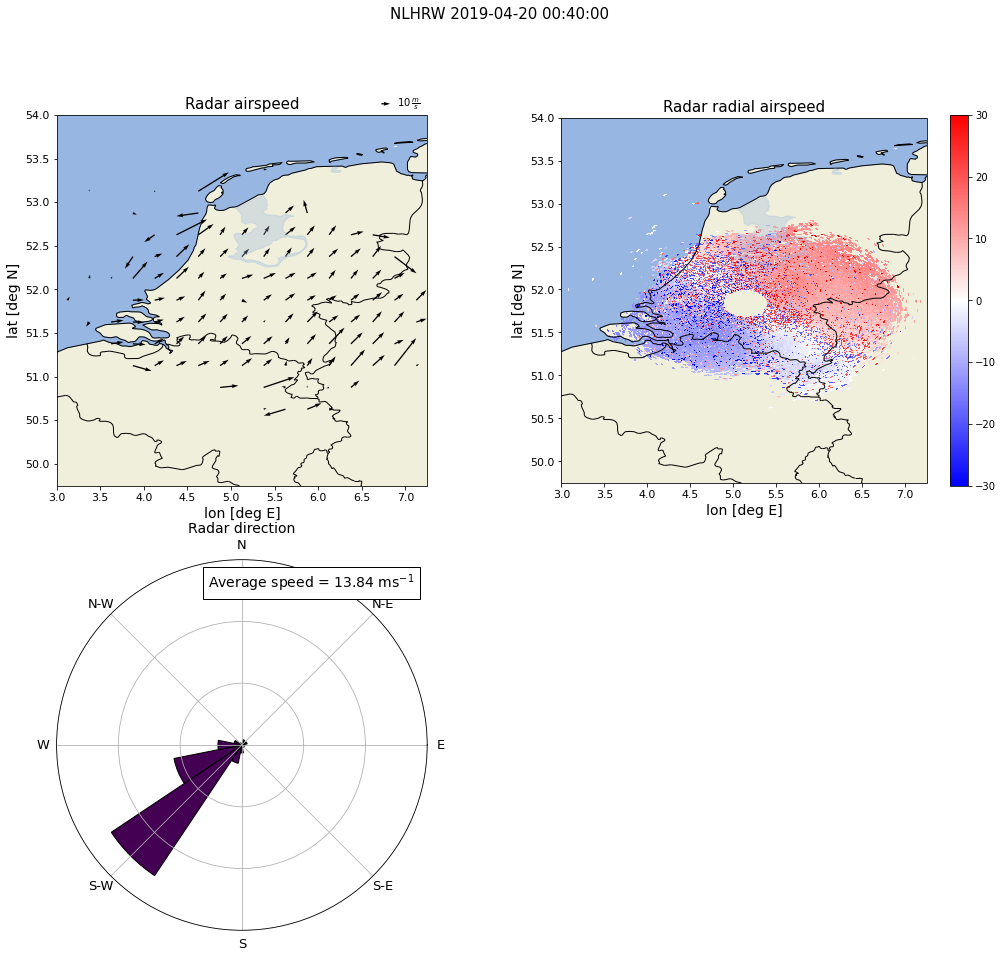

In [113]:
plt.figure(figsize=(18,15))

plt.suptitle('NLHRW 2019-04-20 00:40:00', fontsize = 15)

uu = rad_u - Wind_u_2
vv = rad_v - Wind_v_2


### Quiver map
ax1 = plt.subplot(221, projection=ccrs.PlateCarree())
ax1.set_title('Radar airspeed', fontsize = 15) # on + str(ref_date), fontsize = 14)

Q = ax1.quiver(era5_lon+0.125, era5_lat-0.125, uu, vv, units='width')
ax1.quiverkey(Q, X=0.9, Y=1.03, U=10, label=r'$10\/\frac{m}{s}$', labelpos='E')

ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.RIVERS)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)

ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5), fontsize = 11)

ax1.set_xlim([min(era5_lon2), max(era5_lon2)])
ax1.set_ylim([min(era5_lat2), max(era5_lat2)])


### PPI
ax1 = plt.subplot(222, projection=ccrs.PlateCarree())
c = ax1.pcolormesh(rad_lon, rad_lat, VRAD - VRAD_wind, cmap='bwr', vmin=-30, vmax=30)
plt.colorbar(c, ax=ax1)
ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5), fontsize = 11)

ax1.set_xlim([min(era5_lon2), max(era5_lon2)])
ax1.set_ylim([min(era5_lat2), max(era5_lat2)])
ax1.set_title('Radar radial airspeed',fontsize=15)


### windrose
ws = np.sqrt(uu**2 + vv**2)
wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing
#wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction towards which it's blowing

wss=ws[ws>0]
wdd=wd[ws>0]
bins_range = np.arange(0, max(wss), max(wss)) # this sets the legend scale

ax1 = plt.subplot(223, projection='windrose')
plt.title('Radar direction', fontsize = 14)
viridis = plt.get_cmap('viridis')            # change colormap to viridis 
ax1.bar(wdd, wss, normed=True, opening=1, edgecolor='black', bins=bins_range, cmap=viridis)
ax1.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'],fontsize=13)
ax1.set_yticks(np.arange(0, 80, step=20))
anchored_text = AnchoredText('Average speed = {:.2f}'.format(np.average(wss)) + ' ms$^{-1}$', loc=1, prop=dict(size=14))
ax1.add_artist(anchored_text)

Text(0.5, 1.0, 'Radar radial airspeed STD')

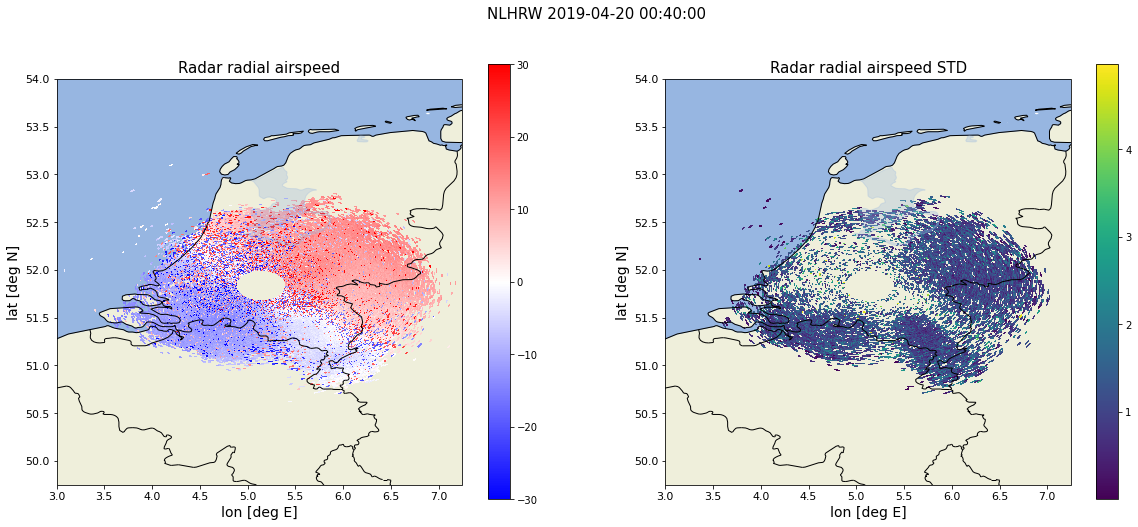

In [84]:
plt.figure(figsize=(20,8))

plt.suptitle('NLHRW 2019-04-20 00:40:00', fontsize = 15)


### PPI
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
c = ax1.pcolormesh(rad_lon, rad_lat, VRAD - VRAD_wind, cmap='bwr', vmin=-30, vmax=30)
plt.colorbar(c, ax=ax1)
ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5), fontsize = 11)

ax1.set_xlim([min(era5_lon2), max(era5_lon2)])
ax1.set_ylim([min(era5_lat2), max(era5_lat2)])
ax1.set_title('Radar radial airspeed',fontsize=15)


VRAD2 = VRAD - VRAD_wind
VRAD2_std = VRAD_std_calc(VRAD2,3,3)
VRAD2_tex = wradlib.dp.texture(VRAD2)
VRAD3_tex = np.copy(VRAD2_tex)
VRAD3_tex[VRAD2_tex>5]=np.nan

### PPI
ax1 = plt.subplot(122, projection=ccrs.PlateCarree())
c = ax1.pcolormesh(rad_lon, rad_lat, VRAD3_tex, cmap='viridis') #, vmin=0, vmax=10)
plt.colorbar(c, ax=ax1)
ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5), fontsize = 11)

ax1.set_xlim([min(era5_lon2), max(era5_lon2)])
ax1.set_ylim([min(era5_lat2), max(era5_lat2)])
ax1.set_title('Radar radial airspeed STD',fontsize=15)

Notes:
- STD of corrected VRAD is higher where there is noise in VRAD: salt-pepper noise in VRAD. It is mostly around the radar location and at the border where velocity goes from positive to zero to negative. So it is a consequence of Doppler velocities
- Low velocities? Are insects? Or another artifact? Where are they?

### Separate high STD from low STD

Text(0.5, 1.0, 'Radar radial airpeed STD')

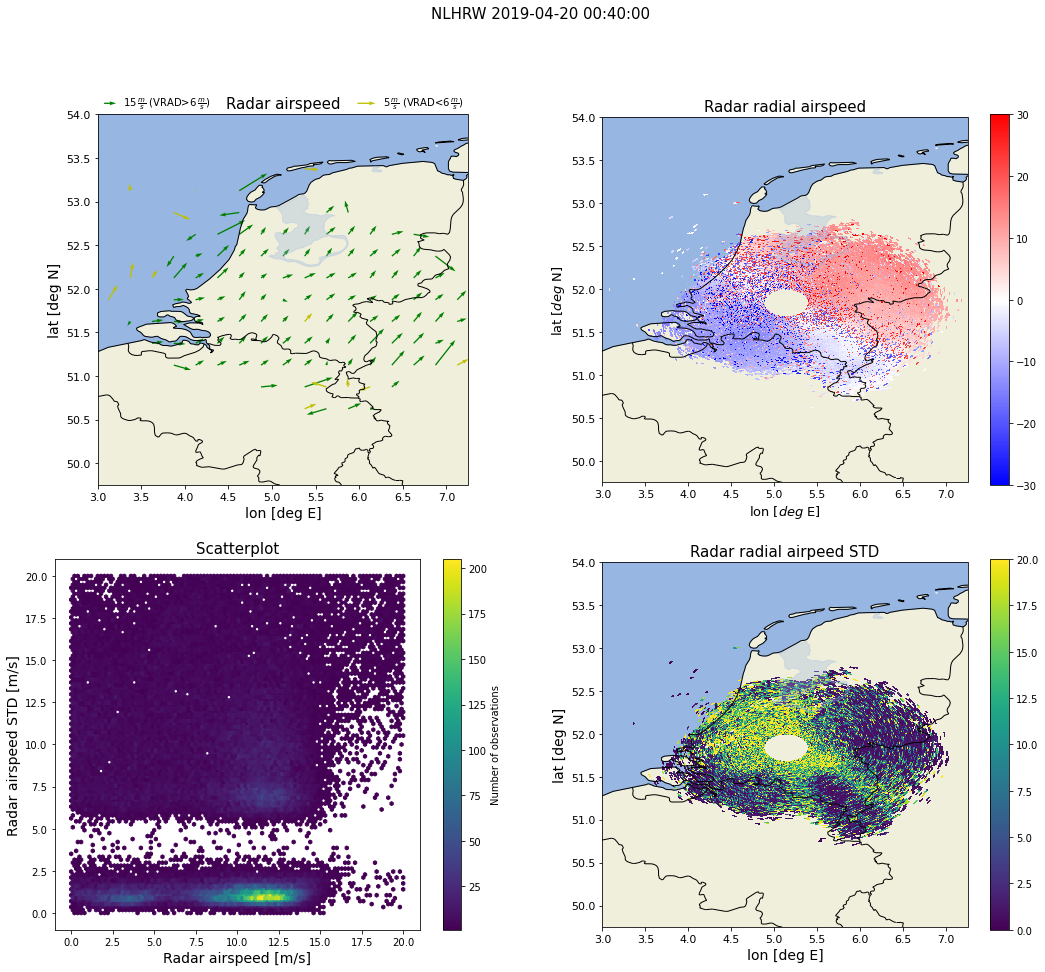

In [88]:
plt.figure(figsize=(18,15))

plt.suptitle('NLHRW 2019-04-20 00:40:00', fontsize = 15)

uu = rad_u - Wind_u_2
vv = rad_v - Wind_v_2
ws = np.sqrt(uu**2 + vv**2)
wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing

uu1 = np.copy(uu)
vv1 = np.copy(vv)
uu2 = np.copy(uu)
vv2 = np.copy(vv)
uu1[ws<5]=np.nan
vv1[ws<5]=np.nan    
uu2[ws>=5]=np.nan
vv2[ws>=5]=np.nan    

### Quiver map
ax1 = plt.subplot(221, projection=ccrs.PlateCarree())
ax1.set_title('Radar airspeed', fontsize = 15) # on + str(ref_date), fontsize = 14)

Q1 = ax1.quiver(era5_lon+0.125, era5_lat-0.125, uu1, vv1, units='width', color='g')
Q2 = ax1.quiver(era5_lon+0.125, era5_lat-0.125, uu2, vv2, units='width', color='y')

ax1.quiverkey(Q1, X=0.05, Y=1.03, U=15, label=r'$15\/\frac{m}{s}$'+r' (VRAD>$6\/\frac{m}{s}$)', labelpos='E')
ax1.quiverkey(Q2, X=0.75, Y=1.03, U=5, label=r'$5\/\frac{m}{s}$'+r' (VRAD<$6\/\frac{m}{s}$)', labelpos='E')

ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.RIVERS)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)

ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5), fontsize = 11)

ax1.set_xlim([min(era5_lon2), max(era5_lon2)])
ax1.set_ylim([min(era5_lat2), max(era5_lat2)])


## PPI
ax1 = plt.subplot(222, projection=ccrs.PlateCarree())
c = ax1.pcolormesh(rad_lon, rad_lat, VRAD - VRAD_wind, cmap='bwr', vmin=-30, vmax=30)
plt.colorbar(c, ax=ax1)
ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax1.set_ylabel('lat [$deg$ N]', fontsize = 13)
ax1.set_xlabel('lon [$deg$ E]', fontsize = 13)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5), fontsize = 11)

ax1.set_xlim([min(era5_lon2), max(era5_lon2)])
ax1.set_ylim([min(era5_lat2), max(era5_lat2)])
ax1.set_title('Radar radial airspeed', fontsize=15)


### Scatterplots
plt.subplot(223)
plt.hexbin(np.absolute(VRAD2[:]),VRAD2_tex[:], mincnt=0.1,gridsize=100,extent=(0,20,0,20)) #,vmax=50)
           #mincnt=1,gridsize=80,extent=(-30,50,-30,50),
           #cmap=plt.cm.magma,
           #bins='log')
#cc=np.corrcoef(results['rad1_dbzh'],results['rad2_dbzh'])[0, 1]
plt.colorbar(label='Number of observations')
plt.xlabel('Radar airspeed [m/s]', fontsize = 14)
plt.ylabel('Radar airspeed STD [m/s]', fontsize = 14)
plt.title('Scatterplot',fontsize=15)


ax1 = plt.subplot(224, projection=ccrs.PlateCarree())
c = ax1.pcolormesh(rad_lon, rad_lat, VRAD2_tex, cmap='viridis', vmin=0, vmax=20)
plt.colorbar(c, ax=ax1)
ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.5), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.5), fontsize = 11)

ax1.set_xlim([min(era5_lon2), max(era5_lon2)])
ax1.set_ylim([min(era5_lat2), max(era5_lat2)])
ax1.set_title('Radar radial airpeed STD',fontsize=15)

Notes:
- Low velocities are localized either over the sea or in the transition part (from positive vel to negative vel). So it's not insects.

### Steps

#### Example of calculation of lon/lat

In [91]:
R = 6378140 #Radius of the Earth [m]
theta = 90 #Bearing is 90 degrees converted to radians.
d = 223 #Distance in m from radar

lat1 = lat_r * (np.pi/180) #Current lat point converted to radians
lon1 = lon_r * (np.pi/180) #Current long point converted to radians

lat2 = np.arcsin( np.sin(lat1)*np.cos(d/R) + np.cos(lat1)*np.sin(d/R)*np.cos(theta))
lon2 = lon1 + np.arctan2(np.sin(theta)*np.sin(d/R)*np.cos(lat1),np.cos(d/R)-np.sin(lat1)*np.sin(lat2))

lat2 = lat2 * (180/np.pi)
lon2 = lon2 * (180/np.pi)


print(lat_r)
print(lon_r)
print(lat2)
print(lon2)

[51.8368988]
[5.13810015]
[51.83600117]
[5.14099843]


#### Plot ERA5 wind

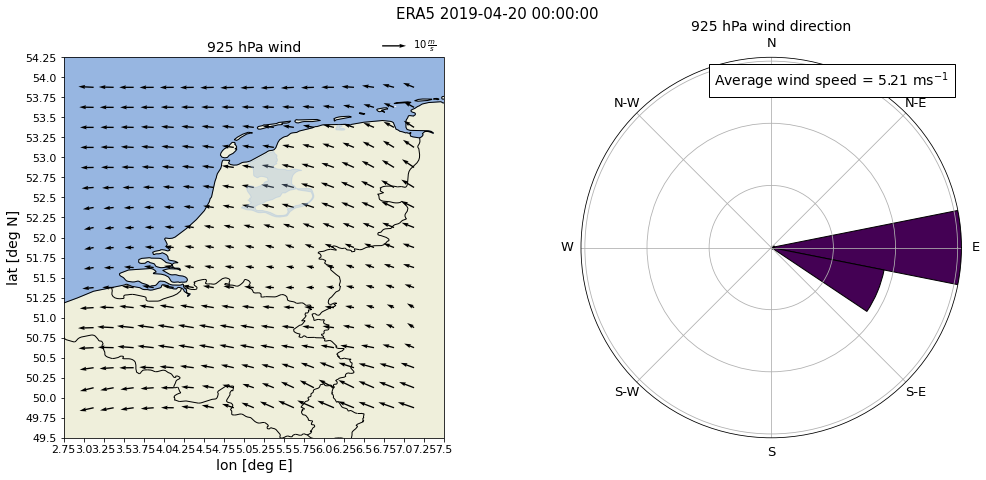

In [92]:
plt.figure(figsize=(17,7))

plt.suptitle('ERA5 ' + str(ref_date), fontsize = 15)

###quiver map
ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.set_title('925 hPa wind', fontsize=14)

Q = ax1.quiver(era5_lon+0.125, era5_lat-0.125, era5_u[time_idx[0][0],-4,:,:], era5_v[time_idx[0][0],-4,:,:], units='width')
ax1.quiverkey(Q, X=0.9, Y=1.03, U=10, label=r'$10\/\frac{m}{s}$', labelpos='E')

ax1.coastlines()
ax1.add_feature(cartopy.feature.LAND)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax1.add_feature(cartopy.feature.OCEAN)
#ax1.add_feature(cartopy.feature.RIVERS)
ax1.add_feature(cartopy.feature.LAKES,alpha=0.3)

ax1.set_ylabel('lat [deg N]', fontsize = 14)
ax1.set_xlabel('lon [deg E]', fontsize = 14)
ax1.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax1.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))
ax1.set_yticklabels(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25), fontsize = 11)
ax1.set_xticklabels(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25), fontsize = 11)

ax1.set_xlim([min(era5_lon2)-0.25, max(era5_lon2)+0.25])
ax1.set_ylim([min(era5_lat2)-0.25, max(era5_lat2)+0.25])


###windrose
uu = era5_u[time_idx[0][0],-4,:,:]
vv = era5_v[time_idx[0][0],-4,:,:]
ws = np.sqrt(uu**2 + vv**2)

wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction from which it's blowing
#wd = np.mod((180+180/np.pi*np.arctan2(uu,vv)),360) #direction towards which it's blowing

wss=ws[ws>0]
wdd=wd[ws>0]
bins_range = np.arange(0, max(wss), max(wss)) # this sets the legend scale

ax1 = plt.subplot(122, projection='windrose')
plt.title('925 hPa wind direction', fontsize = 14)
viridis = plt.get_cmap('viridis')            # change colormap to viridis 
ax1.bar(wdd, wss, normed=True, opening=1, edgecolor='black', bins=bins_range, cmap=viridis)
ax1.set_xticklabels(['E','N-E','N','N-W','W','S-W','S','S-E'],fontsize=13)
ax1.set_yticks(np.arange(0, 80, step=20))
anchored_text = AnchoredText('Average wind speed = {:.2f}'.format(np.average(wss)) + ' ms$^{-1}$', loc=1, prop=dict(size=14))
ax1.add_artist(anchored_text)


#### Plot ERA5 wind in radar PPI

Text(0.5, 1.0, 'v')

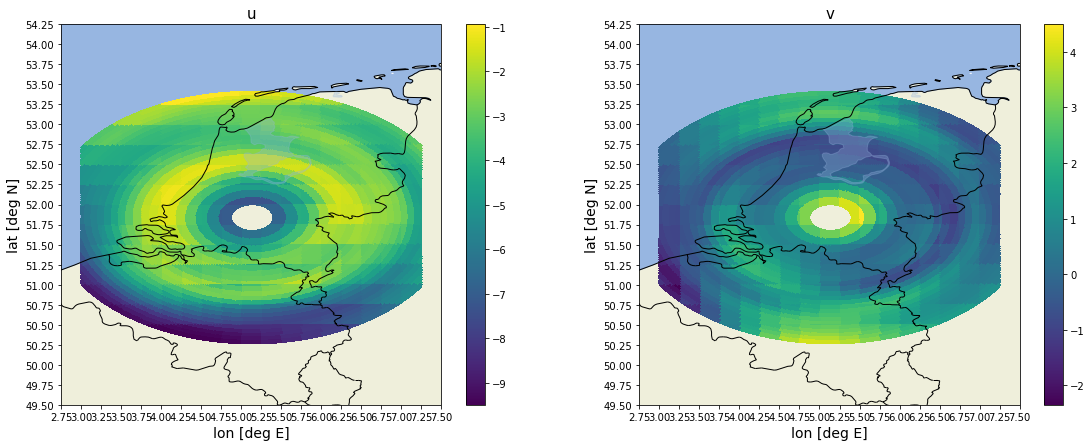

In [106]:
plt.figure(figsize=(19,7))


ax = plt.subplot(121, projection=ccrs.PlateCarree())
c = ax.pcolormesh(rad_lon, rad_lat, VRAD_u_corr) #, vmin=-250000, vmax=500000)
plt.colorbar(c, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha=0.3)


ax.set_ylabel('lat [deg N]', fontsize = 14)
ax.set_xlabel('lon [deg E]', fontsize = 14)
ax.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))

ax.set_xlim([min(era5_lon2)-0.25, max(era5_lon2)+0.25])
ax.set_ylim([min(era5_lat2)-0.25, max(era5_lat2)+0.25])
ax.set_title('u', fontsize=15)


ax = plt.subplot(122, projection=ccrs.PlateCarree())
c = ax.pcolormesh(rad_lon, rad_lat, VRAD_v_corr) #, vmin=-250000, vmax=500000)
plt.colorbar(c, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha=0.3)


ax.set_ylabel('lat [deg N]', fontsize = 14)
ax.set_xlabel('lon [deg E]', fontsize = 14)
ax.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))

ax.set_xlim([min(era5_lon2)-0.25, max(era5_lon2)+0.25])
ax.set_ylim([min(era5_lat2)-0.25, max(era5_lat2)+0.25])
ax.set_title('v', fontsize=15)

#### Convert ERA5 wind to radial

In [98]:
VRAD_wind = np.cos(ele*np.pi/180)*np.cos(TT)*Wind_v + np.cos(ele*np.pi/180)*np.sin(TT)*Wind_u

#### Plot ERA5 radial wind

Text(0.5, 1.0, 'ERA5 radaial velocity')

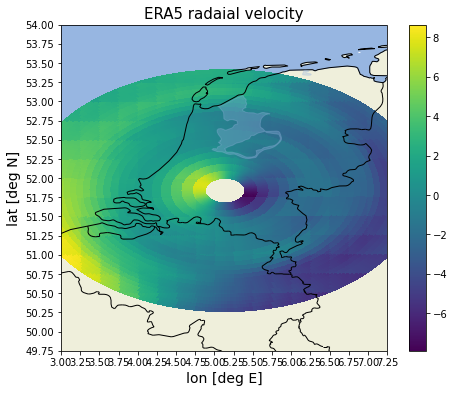

In [108]:
plt.figure(figsize=(8,6))

ax = plt.subplot(111, projection=ccrs.PlateCarree())
c = ax.pcolormesh(rad_lon, rad_lat, VRAD_wind) #, vmin=-250000, vmax=500000)
plt.colorbar(c, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax.set_ylabel('lat [deg N]', fontsize = 14)
ax.set_xlabel('lon [deg E]', fontsize = 14)
ax.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))

ax.set_xlim([min(era5_lon2), max(era5_lon2)])
ax.set_ylim([min(era5_lat2), max(era5_lat2)])
ax.set_title('ERA5 radaial velocity', fontsize=15)

#### Correct radar VRAD for ERA5 radial wind

Text(0.5, 1.0, 'VRAD - ERA5 radial velocity')

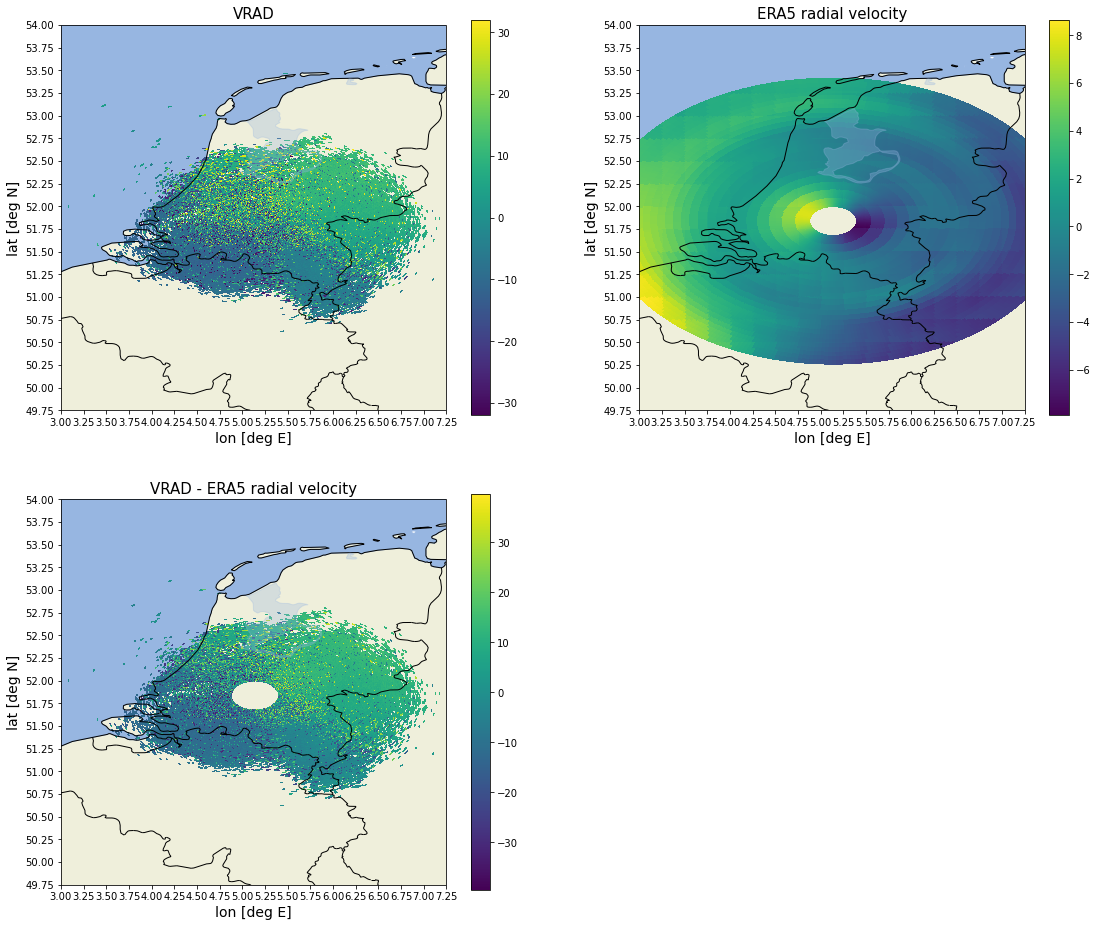

In [109]:
plt.figure(figsize=(19,16))


ax = plt.subplot(221, projection=ccrs.PlateCarree())
c = ax.pcolormesh(rad_lon, rad_lat, VRAD) #, vmin=-250000, vmax=500000)
plt.colorbar(c, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax.set_ylabel('lat [deg N]', fontsize = 14)
ax.set_xlabel('lon [deg E]', fontsize = 14)
ax.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))

ax.set_xlim([min(era5_lon2), max(era5_lon2)])
ax.set_ylim([min(era5_lat2), max(era5_lat2)])
ax.set_title('VRAD', fontsize=15)



ax = plt.subplot(222, projection=ccrs.PlateCarree())
c = ax.pcolormesh(rad_lon, rad_lat, VRAD_wind) #, vmin=-250000, vmax=500000)
plt.colorbar(c, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax.set_ylabel('lat [deg N]', fontsize = 14)
ax.set_xlabel('lon [deg E]', fontsize = 14)
ax.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))

ax.set_xlim([min(era5_lon2), max(era5_lon2)])
ax.set_ylim([min(era5_lat2), max(era5_lat2)])
ax.set_title('ERA5 radial velocity', fontsize=15)



ax = plt.subplot(223, projection=ccrs.PlateCarree())
c = ax.pcolormesh(rad_lon, rad_lat, VRAD - VRAD_wind) #, vmin=-250000, vmax=500000)
plt.colorbar(c, ax=ax)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES,alpha=0.3)


ax.set_ylabel('lat [deg N]', fontsize = 14)
ax.set_xlabel('lon [deg E]', fontsize = 14)
ax.set_yticks(np.arange(min(era5_lat)-0.5, max(era5_lat)+1, 0.25))
ax.set_xticks(np.arange(min(era5_lon)-0.5, max(era5_lon)+1, 0.25))

ax.set_xlim([min(era5_lon2), max(era5_lon2)])
ax.set_ylim([min(era5_lat2), max(era5_lat2)])
ax.set_title('VRAD - ERA5 radial velocity', fontsize=15)

#### Plot histograms of VRAD and corrected VRAD

Text(0.5, 1.0, 'VRAD - ERA5 radial velocity')

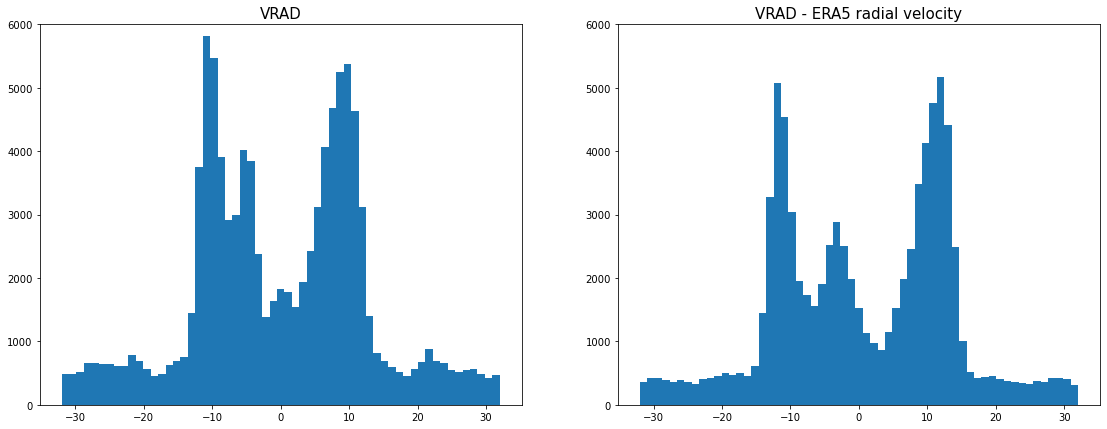

In [112]:
VRAD_corr = VRAD - VRAD_wind

bins = np.linspace(-32, 32, 60)

plt.figure(figsize=(19,7))

ax = plt.subplot(121)
bins = np.linspace(-32, 32, 60)
ax.hist(VRAD[VRAD>-32],bins)
ax.set_ylim(0,6000)
ax.set_title('VRAD', fontsize=15)

ax = plt.subplot(122)
ax.hist(VRAD_corr[VRAD_corr>-32],bins)
ax.set_ylim(0,6000)
ax.set_title('VRAD - ERA5 radial velocity',fontsize=15)

Next steps:
- Extend to more radar elevations (ele = 08.deg so far)
- Interpolation of velocities over lat/lon
- Use different (better) approximation for elevation than standard barometric formula
- Least square interpolation. Imporve it. Learn from Volume Velocity Processing (VVP) verus Velocity Azimuth Display (VAD).